**Team Members: Ethan Wong, Timmy Ren, Mason Shu, Medha Nalamada, Carson Mullen, Bethel Kim**

**Morning Cohort (11 AM - 1 PM)**

*Note to all: Please pull any changes from the repo before working on this file!*

In [3]:
# Install Libraries
# !pip install deep-translator
# !pip install langdetect
# !pip install vaderSentiment
# !pip install openai==0.27.2
# !pip install spacy
# !python -m spacy download en_core_web_md

In [104]:
# Import Libraries
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import (
    TimeoutException,
    NoSuchElementException,
    ElementClickInterceptedException,
    WebDriverException,
)
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import numpy as np
import json
from deep_translator import GoogleTranslator
from langdetect import detect
from collections import Counter
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import openai
import spacy # type: ignore
import random
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Task A: Scrape from ratebeer.com - extract 5-6K reviews

In [ ]:
def handle_cookie_consent():
    try:
        WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.ID, "onetrust-banner-sdk"))
        )
        accept_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//button[@id='onetrust-accept-btn-handler']"))
        )
        accept_button.click()
        WebDriverWait(driver, 5).until(
            EC.invisibility_of_element_located((By.ID, "onetrust-banner-sdk"))
        )
    except (TimeoutException, NoSuchElementException, WebDriverException):
        pass

def handle_ratebeer_banner():
    try:
        WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'RateBeerBestBanner___StyledDiv-jAauHc'))
        )
        close_button = driver.find_element(By.CSS_SELECTOR, '.RateBeerBestBanner___StyledDiv-jAauHc .MuiIconButton-root')
        close_button.click()
        WebDriverWait(driver, 5).until(
            EC.invisibility_of_element_located((By.CLASS_NAME, 'RateBeerBestBanner___StyledDiv-jAauHc'))
        )
    except (TimeoutException, NoSuchElementException, WebDriverException):
        pass

json_file_path = 'beer_reviews.json'
with open(json_file_path, 'w', encoding='utf-8') as f:
    f.write('[')

chrome_options = Options()
chrome_options.add_argument("--headless")  # Run in headless mode
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--window-size=1920,1080")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option('useAutomationExtension', False)

driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()), options=chrome_options
)
driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")

# Navigate to the RateBeer Top Beers page
driver.get("https://www.ratebeer.com/top-beers")

handle_cookie_consent()

WebDriverWait(driver, 10).until(
    EC.presence_of_all_elements_located(
        (By.XPATH, "//div[contains(@class,'DataTable__Row')]/div[2]/a")
    )
)

# Get the list of beers and their links
beer_elements = driver.find_elements(By.XPATH, "//div[contains(@class,'DataTable__Row')]/div[2]/a")
beers = []
for beer_element in beer_elements:
    full_text = beer_element.text
    product_name = full_text.split('\n')[0]  # Take the first line before the newline
    product_link = beer_element.get_attribute('href')
    beers.append({'name': product_name, 'link': product_link})

total_reviews_collected = 0
max_reviews = 30000  # Set your desired number of reviews to collect
first_review = True  # Flag to handle commas in JSON

# Loop through all beers
for i in range(len(beers)):
    product_name = beers[i]['name']
    product_link = beers[i]['link']

    # Navigate to the beer page
    driver.get(product_link)

    handle_cookie_consent()
    handle_ratebeer_banner()

    # Wait for the dropdown to be present
    try:
        dropdown = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "MuiSelect-selectMenu"))
        )
        dropdown.click()

        # Wait for the dropdown options to be visible
        option_100 = WebDriverWait(driver, 10).until(
            EC.visibility_of_element_located((By.XPATH, "//li[contains(text(), '100')]"))
        )
        option_100.click()
    except (TimeoutException, NoSuchElementException, WebDriverException):
        continue

    # Get the total number of reviews
    try:
        num_items_text = driver.find_element(By.CSS_SELECTOR, ".MuiTablePagination-selectRoot + .MuiTypography-colorInherit").text
        total_reviews = int(num_items_text.split(" ")[-1])
        num_pages = int(np.ceil(total_reviews / 100))
    except (NoSuchElementException, ValueError, WebDriverException):
        continue

    for j in range(num_pages):
        time.sleep(2)
        # Expand all "Show more" buttons
        while True:
            try:
                show_more_button = driver.find_element(By.XPATH, "//span[text()='Show more']")
                driver.execute_script("arguments[0].scrollIntoView(true);", show_more_button)
                show_more_button.click()
                time.sleep(1)
            except NoSuchElementException:
                break
            except ElementClickInterceptedException:
                handle_ratebeer_banner()
                driver.execute_script("arguments[0].click();", show_more_button)
            except Exception as e:
                print(f"Could not click 'Show more' button: {e}")
                break

        # Get all comments and store as a list
        comments_elements = driver.find_elements(By.CSS_SELECTOR, ".pre-wrap.MuiTypography-body1")
        product_reviews = [comment.text for comment in comments_elements]

        rating_elements = driver.find_elements(By.CSS_SELECTOR, ".bRPQdN.MuiTypography-subtitle1")
        ratings = [rating.text for rating in rating_elements]

        beer_data_list = []

        for review, rating in zip(product_reviews, ratings):
            beer_data = {
                'product_name': product_name,
                'product_review': review,
                'rating': rating
            }
            beer_data_list.append(beer_data)
            total_reviews_collected += 1

            if total_reviews_collected >= max_reviews:
                break

        # Write data to the JSON file
        with open(json_file_path, 'a', encoding='utf-8') as f:
            for beer_data in beer_data_list:
                if not first_review:
                    f.write(',\n')
                json.dump(beer_data, f, ensure_ascii=False)
                first_review = False
        beer_data_list = []

        if total_reviews_collected >= max_reviews:
            break

        if j + 1 < num_pages:
            try:
                button_to_click = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, ".MuiIconButton-colorInherit + .MuiIconButton-colorInherit"))
                )
                handle_ratebeer_banner()
                button_to_click.click()
                time.sleep(1)
            except ElementClickInterceptedException:
                handle_ratebeer_banner()
                driver.execute_script("arguments[0].click();", button_to_click)
            except Exception as e:
                print(f"Could not click 'Next' button: {e}")
                break

    if total_reviews_collected >= max_reviews:
        break

# Close the JSON array properly
with open(json_file_path, 'a', encoding='utf-8') as f:
    f.write(']')

driver.quit()

In [3]:
# Load the JSON data into a DataFrame
with open('beer_reviews.json', 'r', encoding='utf-8') as file:
    beer_reviews = json.load(file)

df = pd.DataFrame(beer_reviews)
df.head(5)

,product_name,product_review,rating
0,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3
1,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5
2,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3
3,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7
4,Toppling Goliath Kentucky Brunch,"From backlog. (As 2018 Vintage) 0,3 litre Bott...",4.9


In [4]:
# Downsampling Reviews
freq = pd.DataFrame(df.value_counts('product_name')).reset_index()
freq.columns = ['product_name', 'count']
filtered_df = df[df['product_name'].isin(freq[freq['count'] > 200]['product_name'])]

In [6]:
sampled_df = filtered_df.groupby('product_name', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))

In [7]:
sampled_df.head(5)

,product_name,product_review,rating
8629,3 Fonteinen J & J Oude Geuze Blauw,"At Heeren van Liedekercke, with S&G Tasting gr...",4.3
8617,3 Fonteinen J & J Oude Geuze Blauw,Bottle (6-9-2003) at the DC Mini Tasting. Than...,4.4
8800,3 Fonteinen J & J Oude Geuze Blauw,Shared by Ygtbsm94. Thanks Brad. Smells like...,4.0
8780,3 Fonteinen J & J Oude Geuze Blauw,750ml bottle sampled at the DC Local tasting. ...,4.5
8823,3 Fonteinen J & J Oude Geuze Blauw,I hope nobody minds this placeholder rating fo...,5.0


In [8]:
sampled_df.value_counts('product_name')

product_name
3 Fonteinen J & J Oude Geuze Blauw                          100
3 Fonteinen Oude Geuze 1998 (50th Anniversary)              100
AleSmith Speedway Stout                                     100
AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee     100
AleSmith Speedway Stout - Bourbon Barrel Aged               100
Bell's Black Note Stout                                     100
Cigar City Hunahpu's Imperial Stout                         100
Cigar City Hunahpu's Imperial Stout - Double Barrel Aged    100
De Dolle Stille Nacht Reserva 2000                          100
Founders CBS (Canadian Breakfast Stout)                     100
Founders KBS (Kentucky Breakfast Stout)                     100
Goose Island Bourbon County Stout - Proprietor's 2013       100
Goose Island Bourbon County Stout - Rare 2010               100
La Face Cachée de la Pomme Neige Récolte d'Hiver            100
Närke Kaggen Stormaktsporter                                100
Perennial Abraxas - Barrel-

In [49]:
#sampled_df.to_csv('sampled_beer_review.csv')

In [50]:
# Function to translate text to English if it's not already in English
def translate_to_english_if_needed(text):
    try:
        # Detect the language of the text
        lang = detect(text)
        # Translate only if the language is not English
        if lang != 'en':
            translated = GoogleTranslator(source='auto', target='en').translate(text)
            return translated
        else:
            return text
    except Exception as e:
        return str(e)

# Apply the translation function to the 'product_review' column
sampled_df['product_review'] = sampled_df['product_review'].apply(translate_to_english_if_needed)

In [51]:
# Export the DataFrame to a CSV or json file to prevent re-running the code in the future
#sampled_df.to_csv('final_beer_reviews.csv', index=False)

# Task B: Perform a word frequency analysis to find the most important beer attributes and ensure that the attributes specified are likely to be mentioned together in a review

In [106]:
#Load final reviews dataframe 
df = pd.read_csv('final_beer_reviews.csv')

#Word frequency analysis of entire df 
df['product_review'] = df['product_review'].apply(str)
all_text = ' '.join(df['product_review'].dropna())
words = re.findall(r'\w+', all_text.lower())
word_counts = Counter(words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

#Define a common list of attributes to search through 
attributes = [
    'aggressive', 'balanced', 'crisp', 'sweet', 'diacetyl', 'estery', 'floral', 'fruity', 'malty', 
    'robust', 'light', 'hoppy', 'bitter', 'clove', 'dry', 'earthy', 'herbal', 'nutty', 'piney', 
    'spicy', 'tart', 'woody', 'creamy', 'toast', 'smooth', 'oaky',
    'peppery', 'zesty', 'citrus', 'pungent', 'sour', 'smoky', 'fragrant', 'lingering',
    'thin', 'yeasty', 'burnt', 'rich', 'mellow', 'clean', 'dank', 
    'warming',
]

attribute_freq = word_freq_df[word_freq_df['Word'].isin(attributes)]
top_attributes = attribute_freq.sort_values(by='Frequency', ascending=False)
top_25_attributes = top_attributes[:25]['Word']
top_25_attributes_list = top_25_attributes.str.lower().tolist()
print('Top 25 Attributes:\n', top_25_attributes)

Top 25 Attributes:
 227         sweet
196         light
457        smooth
212          rich
835        bitter
220        creamy
536      balanced
172           dry
177          sour
770          thin
87         fruity
282        citrus
736       warming
191          tart
913         malty
441         spicy
1656        burnt
458         woody
349        earthy
284     lingering
637       peppery
549          oaky
281        floral
2426        hoppy
994        mellow
Name: Word, dtype: object


Before we select 3 attributes, doing a lift analysis will help us see strongly co-occuring attributes that can be used as an ideal selection

In [109]:
#Performing a lift analysis to assess their associations within a message
from itertools import combinations
from collections import defaultdict

# Top 3 attributes
input_attributes = top_25_attributes_list

def clean_text(text):
    text = re.sub(r'\W+', ' ', text.lower())  # Remove punctuation and convert to lowercase
    words = text.split()
    return words 

def find_attribute_pairs(message, attributes, window=50):
    message = re.sub(r'\W+', ' ', message.lower())  # Clean the message
    words = message.split()
    attribute_indices = {attribute: [] for attribute in attributes}

    # Track the position of each attribute in the message
    for i, word in enumerate(words):
        if word in attributes:
            attribute_indices[word].append(i)

    # Find pairs within the given window
    attribute_pairs = set()
    attribute_list = list(attribute_indices.keys())
    for idx1, attribute1 in enumerate(attribute_list):
        indices1 = attribute_indices[attribute1]
        for idx2 in range(idx1 + 1, len(attribute_list)):
            attribute2 = attribute_list[idx2]
            indices2 = attribute_indices[attribute2]
            for i1 in indices1:
                for i2 in indices2:
                    if abs(i1 - i2) - 1 <= window:
                        pair = tuple(sorted((attribute1, attribute2)))
                        attribute_pairs.add(pair)
    return attribute_pairs

# Function to calculate word frequencies and word pair co-occurrences
def calculate_frequencies(df, input_attributes, window=50):
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(int)

    # Loop through each post and count word occurrences
    for index, row in df.iterrows():
        message = row['product_review']
        words_in_message = set(clean_text(message))
        attributes_in_message = words_in_message.intersection(input_attributes)
        
        # Update word frequencies
        for attribute in attributes_in_message:
            word_frequency[attribute] += 1

        # Update pair frequencies
        attribute_pairs = find_attribute_pairs(message, input_attributes, window=window)
        for attribute_pair in attribute_pairs:
            if attribute_pair[0] in attributes_in_message and attribute_pair[1] in attributes_in_message:
                word_pair_frequency[attribute_pair] += 1

    return word_frequency, word_pair_frequency


# Function to calculate lift
def calculate_lift(word_frequency, word_pair_frequency, total_posts):
    lift_values = []

    for (attribute1, attribute2), pair_count in word_pair_frequency.items():
        p_attribute1 = word_frequency[attribute1] / total_posts
        p_attribute2 = word_frequency[attribute2] / total_posts
        p_both = pair_count / total_posts

        if p_attribute1 * p_attribute2 > 0:
            lift = p_both / (p_attribute1 * p_attribute2)
            lift_values.append({
                'Attribute 1': attribute1,
                'Attribute 2': attribute2,
                'Lift': lift
            })

    return pd.DataFrame(lift_values)

# Main function to process data and compute lift ratios
def main(df, top_10_brands_list, window=50):
    # Step 1: Calculate word and word pair frequencies
    total_posts = len(df)
    word_frequency, word_pair_frequency = calculate_frequencies(df, input_attributes, window)
    
    # Step 2: Calculate lift values
    lift_df = calculate_lift(word_frequency, word_pair_frequency, total_posts)
    
    # Step 3: Create lift matrix
    lift_matrix = lift_df.pivot(index='Attribute 1', columns='Attribute 2', values='Lift')
    
    # Ensure all attributes are present in both axes
    all_attributes = sorted(set(input_attributes))
    lift_matrix = lift_matrix.reindex(index=all_attributes, columns=all_attributes)
    
    # Replace missing values with 0
    lift_matrix = lift_matrix.fillna(0)
    
    # Convert DataFrame to object type to allow setting string values
    lift_matrix = lift_matrix.astype(object)
    
    # Set the diagonal and lower triangle to '-'
    for i in range(len(all_attributes)):
        lift_matrix.iloc[i, i] = '-'  # Set diagonal to '-'
        for j in range(i):
            lift_matrix.iloc[i, j] = '-'  # Set lower triangle to '-'
    
    # Remove labels from being displayed
    lift_matrix.index.name = None
    lift_matrix.columns.name = None
    
    # Return both lift_matrix and lift_df
    return lift_matrix, lift_df

# Execute the main function and capture the lift matrix and lift DataFrame
lift_matrix, lift_df = main(df, input_attributes, window=5000)

#Filter the matrix to include only high associations
filtered_lift_df = lift_df[(lift_df['Lift'] > 2) & (lift_df['Lift'] <= 4)]

In [111]:
#Function to select three attributes that have the highest lifts among all trio combinations
def find_top_trios(filtered_lift_df, top_n=1):
    
    trio_lift_sums = defaultdict(float)
    
    # Create a set of all unique attributes involved in the filtered lift pairs
    unique_attributes = set(filtered_lift_df['Attribute 1']).union(set(filtered_lift_df['Attribute 2']))
    
    # Generate all possible combinations of three attributes
    for trio in combinations(unique_attributes, 3):
        a1, a2, a3 = sorted(trio)
        
        # Get the lift values for each pair in the trio
        lift_a1_a2 = filtered_lift_df[(filtered_lift_df['Attribute 1'] == a1) & (filtered_lift_df['Attribute 2'] == a2)]['Lift']
        lift_a1_a3 = filtered_lift_df[(filtered_lift_df['Attribute 1'] == a1) & (filtered_lift_df['Attribute 2'] == a3)]['Lift']
        lift_a2_a3 = filtered_lift_df[(filtered_lift_df['Attribute 1'] == a2) & (filtered_lift_df['Attribute 2'] == a3)]['Lift']
        
        # Calculate the sum
        if not lift_a1_a2.empty and not lift_a1_a3.empty and not lift_a2_a3.empty:
            trio_lift_sums[trio] = lift_a1_a2.values[0] + lift_a1_a3.values[0] + lift_a2_a3.values[0]

    # Sort the trios
    sorted_trios = sorted(trio_lift_sums.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_trios = [{'Attributes': triad, 'Lift Sum': lift_sum} for triad, lift_sum in sorted_trios]
    
    return pd.DataFrame(top_trios)

# Display the top 3 trios
top_three_trios = find_top_trios(filtered_lift_df, top_n=3)
top_three_trios

,Attributes,Lift Sum
0,"(citrus, earthy, sour)",10.650483
1,"(hoppy, peppery, lingering)",10.245056
2,"(citrus, tart, earthy)",10.046699


Based on our finding here, we will use earthy, citrus, and sour as the three attributes chosen by the customer!

# Task C: Perform a similarity analysis using cosine similarity with the three attributes specified by the customer and the reviews

**Note: Used the bag-of-words model as opposed to word embeddings**

In [115]:
# Script should accept a file as input that has the product attributes and calculate similarity scores (0-1) 
    # between these attributes and each review
# Output file should have three columns: product_name (will have a row for each review), product_review, 
    # and similarity_score

In [117]:
# Function to calculate cosine similarity between attributes and multiple reviews 
# based on cosine similarity code Dr. Barua posted
def calculate_similarity(attributes, reviews):
    # Combine the attributes into one string (bag of words)
    attributes_combined = ' '.join(attributes)
    
    # Combine the reviews into a list (to be vectorized) and add attributes as the first document
    documents = [attributes_combined] + list(reviews)  # First document is the attributes
    
    # Use CountVectorizer to convert text to bag-of-words representation
    count_vectorizer = CountVectorizer(stop_words='english')
    sparse_matrix = count_vectorizer.fit_transform(documents)  # Vectorize all documents
    
    # Convert sparse matrix to dense (using todense()) for normalization and cosine similarity calculation
    doc_term_matrix = sparse_matrix.todense()  # Using todense() as in the reference code
    
    # Normalize the term-document matrix by dividing each count by the sum of counts in the document
    doc_term_matrix_normalized = doc_term_matrix / doc_term_matrix.sum(axis=1)
    
    # Create a DataFrame from the normalized term-document matrix
    df = pd.DataFrame(doc_term_matrix_normalized, columns=count_vectorizer.get_feature_names_out(), index=['attributes'] + [f'review_{i}' for i in range(len(reviews))])
    
    # Calculate cosine similarity between the first document (attributes) and each review
    similarity_scores = cosine_similarity(df.iloc[0:1], df.iloc[1:]).flatten()  # Skip first row (attributes)
    
    return similarity_scores

In [119]:
# Execute cosine similarity function and capture similarities for chosen attributes 

attributes = ['citrus', 'earthy', 'sour']  
reviews = df['product_review']
product_names = df['product_name'] 

# Calculate similarity for all reviews
similarity_scores = calculate_similarity(attributes, reviews)

# Create a new DataFrame with product_name, product_review, and similarity_score
output_df = pd.DataFrame({
    'product_name': product_names,
    'product_review': reviews,
    'similarity_score': similarity_scores
})

In [121]:
# Sort output_df by similarity_score in descending order (highest to lowest)
output_df_sorted = output_df.sort_values(by='similarity_score', ascending=False)

# Display the first few rows of the sorted DataFrame
output_df_sorted.head()

,product_name,product_review,similarity_score
64,3 Fonteinen J & J Oude Geuze Blauw,(Bottle 75 cl) Courtesy of yespr. Pours a clou...,0.400320
156,3 Fonteinen Oude Geuze 1998 (50th Anniversary),"Beer #10000! Bottle at Akkurat, Stockholm. Cle...",0.383598
814,De Dolle Stille Nacht Reserva 2000,"#1900, thanks to bu11zeye, cloudy color of gra...",0.361158
107,3 Fonteinen Oude Geuze 1998 (50th Anniversary),"Bottled @RBESG’05\r\n\r\nPale yellow, creamy w...",0.353553
126,3 Fonteinen Oude Geuze 1998 (50th Anniversary),"Big, big thanks Jason for opening this one up ...",0.348155


In [123]:
# Count rows where similarity_score is greater than 0
rows_with_similarity = output_df[output_df['similarity_score'] > 0].shape[0]
print(f"Number of rows with similarity score > 0: {rows_with_similarity}")

Number of rows with similarity score > 0: 277


In [125]:
#output_df.to_csv('cos_similiarities.csv', index=False)

# Task D: Perform a sentiment analysis for every review

In [85]:
# Used ChatGPT to generate sentiment scores for each review

with open('api_key.json') as f:
    config = json.load(f)


openai.api_key = config['api_key']

def convert_int(s):
    s = s.strip()
    try:
        int(s)
        return True
    except ValueError:
        try:
            float(s)
            return True
        except ValueError:
            return False

def get_sentiment(review_text, rating):
    non_int_count = 0
    
    while non_int_count < 2:
        completion = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {
                    "role": "user", 
                    "content": f"""
                    You are a sentiment analysis expert trained to evaluate beer reviews. Your task is to provide sentiment scores for each beer review on a scale from -100 (extremely negative) to 100 (extremely positive).
                    - Use the rating (1-5) to detect sarcasm if the text contains clear cues.
                    - Do not assume sarcasm solely due to mismatched sentiment and rating.
                    - Only output the sentiment score as an integer. Only 1 sentiment score should be outputted, regardless of number of reviews given.
                    Review: "{review_text}"
                    Rating: {rating} out of 5
                    Response Format: [sentiment value]
                    """
                }
            ],
            temperature = 0
        )
        sentiment = completion.choices[0].message['content'].strip()
        print(f"Sentiment value received: '{sentiment}', Type: {type(sentiment)}")
        if convert_int(sentiment):
            return sentiment
        else:
            non_int_count += 1
            print(sentiment)
        
    raise ValueError(f"Error: More than 2 consecutive non-integer sentiment values encountered for review: '{review_text}'")

In [ ]:
# Apply the sentiment analysis function to the DataFrame
# df['sentiment'] = df.apply(lambda row: get_sentiment(row['product_review'], row['rating']), axis=1)

In [ ]:
# Export the DataFrame to a CSV file
#df.to_csv('sentiments.csv', index = False)

# Task E: Create an evaluation score for each beer that uses both similarity and sentiment scores and recommended three products to the customer

In [127]:
# Add sentiment and similarity scores for the three products recommended.
# Create a df with product_name, product_review, similarity, sentiment, evaluation
# Use all similarity rows
# Recommend top 3 products based on evaluation

df = pd.read_csv('sentiments.csv')

# Convert sentiment to numeric
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')

# Normalize sentiment scores from -100 to 100 to -1 to 1
df['sentiment'] = df['sentiment'] / 100

df_combined = pd.merge(df, output_df[['product_name', 'product_review', 'similarity_score']], 
                       on=['product_name', 'product_review'], how='inner')

# Calculate evaluation score
df_combined['evaluation_score'] = df_combined['similarity_score'] * df_combined['sentiment']

# Group by product_name and calculate the mean evaluation score for each beer
product_evaluation = df_combined.groupby('product_name')['evaluation_score'].mean().reset_index()

# Rank products
top_products = product_evaluation.sort_values(by='evaluation_score', ascending=False)

# Recommend top 3
top_3_products = top_products.head(3)
print(top_3_products)

                                      product_name  evaluation_score
1   3 Fonteinen Oude Geuze 1998 (50th Anniversary)          0.085702
0               3 Fonteinen J & J Oude Geuze Blauw          0.078048
16                 Russian River Pliny the Younger          0.046181


# Task F: How would our recommendations change if we use word vectors instead of the standard bag-of-words cosine similarity?

In [17]:
# Here we calculate the similarity between the same docs using word vectors (spacy)

# Load the spaCy medium-sized English model
nlp = spacy.load('en_core_web_md')

# Function to calculate cosine similarity between attributes and reviews using spaCy embeddings
def word2vec_sim(attributes, reviews):
    # Combine the attributes into one string
    attributes_combined = ' '.join(attributes)
    
    # Create the spaCy doc for the attributes
    attributes_doc = nlp(attributes_combined)
    
    similarity_scores = [attributes_doc.similarity(nlp(review)) for review in reviews]
    
    return similarity_scores

In [18]:
# Execute cosine similarity function and capture similarities for chosen attributes 

attributes = ['citrus', 'earthy', 'sour']  
reviews = df['product_review']
product_names = df['product_name'] 

# Calculate similarity for all reviews
similarity_scores = word2vec_sim(attributes, reviews)

# Create a new DataFrame with product_name, product_review, and similarity_score
spacy_output_df = pd.DataFrame({
    'product_name': product_names,
    'product_review': reviews,
    'similarity_score': similarity_scores
})

In [19]:
spacy_output_df.sort_values('similarity_score', ascending=False)

,product_name,product_review,similarity_score
260,AleSmith Speedway Stout,Bottle a black colored beer with a beige head ...,0.885468
396,AleSmith Speedway Stout - Barrel-Aged Vietname...,On tap dark vanilla wood coffee licorice good ...,0.859436
770,Cigar City Hunahpu's Imperial Stout - Double B...,Smell is cinnamon dough. Taste is delicious ci...,0.811349
834,De Dolle Stille Nacht Reserva 2000,Bottle at yesprs blindtasting.\r\nHazy orange ...,0.793151
404,AleSmith Speedway Stout - Bourbon Barrel Aged,Excellent stout. Particularly great with a sli...,0.787181
...,...,...,...
818,De Dolle Stille Nacht Reserva 2000,This was an outstanding beer. I paid $22 doll...,0.295919
1559,Perennial Abraxas - Barrel-Aged,This is being rated because they lost one of m...,0.293853
1882,Three Floyds Dark Lord - Bourbon Vanilla Bean,Holy shit!!! I have no words..... \r\n \r\n\r\...,0.292597
1602,Russian River Pliny the Younger,"I've had this twice now and, while it's very g...",0.287224


In [20]:
## If you're having trouble using spaCy read the output df

#spacy_output_df = pd.read_csv('spacy_output.csv')

In [20]:
df = pd.read_csv('sentiments.csv')

# Convert sentiment to numeric
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')

# Normalize sentiment scores from -100 to 100 to -1 to 1
df['sentiment'] = df['sentiment'] / 100

df_combined = pd.merge(df, spacy_output_df[['product_name', 'product_review', 'similarity_score']], 
                       on=['product_name', 'product_review'], how='inner')

# Calculate evaluation score
df_combined['evaluation_score'] = df_combined['similarity_score'] * df_combined['sentiment']

# Group by product_name and calculate the mean evaluation score for each beer
product_evaluation = df_combined.groupby('product_name')['evaluation_score'].mean().reset_index()

# Rank products
top_products = product_evaluation.sort_values(by='evaluation_score', ascending=False)

# Recommend top 3
top_3_products = top_products.head(3)
print(top_3_products)

                                         product_name  evaluation_score
3   AleSmith Speedway Stout - Barrel-Aged Vietname...          0.486373
7   Cigar City Hunahpu's Imperial Stout - Double B...          0.486363
15                    Perennial Abraxas - Barrel-Aged          0.478197


In [21]:
top_products

,product_name,evaluation_score
3,AleSmith Speedway Stout - Barrel-Aged Vietname...,0.486373
7,Cigar City Hunahpu's Imperial Stout - Double B...,0.486363
15,Perennial Abraxas - Barrel-Aged,0.478197
6,Cigar City Hunahpu's Imperial Stout,0.470055
13,La Face Cachée de la Pomme Neige Récolte d'Hiver,0.467695
11,Goose Island Bourbon County Stout - Proprietor...,0.461357
19,Toppling Goliath Mornin' Delight,0.460090
12,Goose Island Bourbon County Stout - Rare 2010,0.450922
5,Bell's Black Note Stout,0.441823
9,Founders CBS (Canadian Breakfast Stout),0.441781


As we can see, the evaluation scores using word vectors are much higher than using bag of words. This change makes sense because word vectors can find higher similarity values, even if the words in the review are not the same words we are looking for (they can find similarity in semantics). As the similarity values increase, the evaluation scores are expected to increase similarly (assumming negative sentiments don't start to overshadow positive ones).

# Task G: How would our recommendations differ if we ignored the similarity and feature sentiment scores and just chose the 3 highest rated products from the entire data set? Would these products meet the requirements of the user looking for recommendations? Why or why not?

In [129]:
# Justify with analysis - use similarity and sentiment scores as well as overall ratings to answer this questions

# Determine top 3 beers by average rating 
avg_ratings = df.groupby('product_name')['rating'].mean().reset_index()
top_3_beers_by_rating = avg_ratings.sort_values(by = 'rating', ascending = False).head(3)
top_3_beers_by_rating

,product_name,rating
7,Cigar City Hunahpu's Imperial Stout - Double B...,4.427
12,Goose Island Bourbon County Stout - Rare 2010,4.425
14,Närke Kaggen Stormaktsporter,4.417


In [131]:
# Evaluation scores of top 3 beers by average rating
top_products[top_products['product_name'].isin(top_3_beers_by_rating['product_name'])]

,product_name,evaluation_score
14,Närke Kaggen Stormaktsporter,0.001940
7,Cigar City Hunahpu's Imperial Stout - Double B...,0.001626
12,Goose Island Bourbon County Stout - Rare 2010,0.001448


In spite of their high ratings, the top 3 highly rated beers, bear very low evaluation scores. These evaluation scores, which combine similarity and sentiment scores, are key in determining how well a product aligns with the specific preferences of a user. In this case, the low evaluation scores suggest that these beers may not meet the user's requirements as effectively as their high ratings would imply. 

It is likely that the low evaluation scores stem from the fact that the similarity between the customer’s specified attributes ("citrus"," "earthy," "sour") and the reviews for these beers may be minimal. This indicates that while these beers are highly rated by a broad audience, they may not possess the characteristics that the customer specifically desires. 

The sentiment scores - derived from the overall tone of the reviews - may not be high enough to elevate the evaluation score. Even though the beers have favorable overall ratings, individual reviews might include critical or neutral sentiments that lower the sentiment score, particularly if reviewers express mixed feelings about certain aspects of the beers. Furthermore, reviews that lack strong associations with the customer’s desired attributes can contribute to lower evaluation scores. If the beers' characteristics do not align with the customer's expectations based on the specified attributes, this mismatch will result in a diminished evaluation score.

# Task H: From 10 beers in the data, choose 1, and find the most similar beer among the remaining 9

In [224]:
# Select 10 Beers from the Dataset
unique_beers = df['product_name'].unique()
selected_beers = random.sample(list(unique_beers), 10)

# Choose one beer as the target beer
chosen_beer = selected_beers[0]
print(f"Chosen Beer: {chosen_beer}")

# Remaining beers to compare with
remaining_beers = selected_beers[1:]
print(f"Remaining Beers: {remaining_beers}")

Chosen Beer: Bell's Black Note Stout
Remaining Beers: ["Cigar City Hunahpu's Imperial Stout - Double Barrel Aged", "Toppling Goliath Mornin' Delight", "La Face Cachée de la Pomme Neige Récolte d'Hiver", 'Westvleteren 12', 'Perennial Abraxas - Barrel-Aged', 'Founders CBS (Canadian Breakfast Stout)', "Goose Island Bourbon County Stout - Proprietor's 2013", 'Founders KBS (Kentucky Breakfast Stout)', 'Trappistes Rochefort 10']


We begin by randomly selecting ten unique beers from the dataset. One beer is designated as the target beer, and the remaining nine beers constitute the comparison group. This selection ensures a diverse set of beers for meaningful comparison.

In [227]:
# Identify Mentioned Attributes in Each Review
# We already have the list of top 25 attributes from Task B
# Ensure attributes are in lowercase
attributes = [attr.lower() for attr in top_25_attributes_list]

# Function to identify attributes in a review
def get_attributes_in_review(review, attributes):
    review_words = set(re.findall(r'\b\w+\b', review.lower()))
    mentioned_attributes = review_words.intersection(attributes)
    return mentioned_attributes

Using the top 25 attributes identified in earlier analysis (such as "hoppy," "fruity," "bitter," etc.), we standardize these attributes by converting them to lowercase to maintain consistency during text matching.

For each review associated with the selected beers, we extract the mentioned attributes. This involves parsing each review to identify words that match our list of attributes. By doing so, we capture the specific aspects of the beers that reviewers have commented on.

In [230]:
# Calculate Average Sentiment per Attribute per Beer
beer_attribute_sentiments = {beer: {attr: [] for attr in attributes} for beer in selected_beers}

# Iterate over each beer and its reviews
for beer in selected_beers:
    beer_reviews = df[df['product_name'] == beer]
    for index, row in beer_reviews.iterrows():
        review = row['product_review']
        sentiment = row['sentiment']
        mentioned_attrs = get_attributes_in_review(review, attributes)
        for attr in mentioned_attrs:
            beer_attribute_sentiments[beer][attr].append(sentiment)

# Calculate average sentiment per attribute per beer
beer_feature_vectors = {}
for beer, attr_sentiments in beer_attribute_sentiments.items():
    feature_vector = []
    for attr in attributes:
        sentiments = attr_sentiments[attr]
        if sentiments:
            avg_sentiment = sum(sentiments) / len(sentiments)
        else:
            avg_sentiment = 0  # Assign 0 if the attribute is not mentioned
        feature_vector.append(avg_sentiment)
    beer_feature_vectors[beer] = feature_vector

Each review in the dataset has an associated sentiment score, reflecting the overall positive or negative tone of the review. For every attribute mentioned in a review, we associate the sentiment score of that review with the attribute. This means that if a review mentions "hoppy" and has a positive sentiment score, "hoppy" will inherit that positive sentiment in the context of that beer.

We aggregate the sentiment scores for each attribute across all reviews of a beer. By calculating the average sentiment score for each attribute, we create a profile that reflects how customers generally feel about each attribute of the beer. Attributes not mentioned in any reviews for a beer are assigned a neutral sentiment score of zero to indicate no available data.

In [233]:
# Construct Feature Vectors for Each Beer
feature_df = pd.DataFrame.from_dict(beer_feature_vectors, orient='index', columns=attributes)

With the average sentiment scores, we constructed a feature vector for each beer. This vector is a numerical representation where each dimension corresponds to one of the top attributes, and the value is the average sentiment score for that attribute.

In [236]:
# Compute Cosine Similarity Between Beers
# Extract the feature vector for the chosen beer
chosen_vector = feature_df.loc[chosen_beer].values.reshape(1, -1)

# Check if the chosen_vector contains NaN values
if np.isnan(chosen_vector).any():
    chosen_vector = np.nan_to_num(chosen_vector)

# Compute cosine similarity between the chosen beer and the remaining beers
similarities = {}
for beer in remaining_beers:
    beer_vector = feature_df.loc[beer].values.reshape(1, -1)
    
    # Check if the beer_vector contains NaN values
    if np.isnan(beer_vector).any():
        beer_vector = np.nan_to_num(beer_vector)
    
    # Handle case where both vectors are zero vectors
    if np.linalg.norm(chosen_vector) == 0 or np.linalg.norm(beer_vector) == 0:
        sim_score = 0.0  # Assign similarity score of 0 if either vector is zero
    else:
        sim_score = cosine_similarity(chosen_vector, beer_vector)[0][0]
    similarities[beer] = sim_score

To quantify the similarity between beers, we compute the cosine similarity between the feature vector of the chosen beer and those of the other beers.

By comparing the cosine similarity scores, we identify the beer with the highest similarity to the chosen beer. This beer is considered the most similar because it shares the most similar sentiment profile across the key attributes identified from customer reviews.

In [239]:
# Identify the Most Similar Beer to the Chosen Beer
# Find the beer with the highest similarity score
most_similar_beer = max(similarities, key=similarities.get)
highest_similarity_score = similarities[most_similar_beer]

print(f"The most similar beer to '{chosen_beer}' is '{most_similar_beer}' with a similarity score of {highest_similarity_score:.4f}.")

The most similar beer to 'Bell's Black Note Stout' is 'Cigar City Hunahpu's Imperial Stout - Double Barrel Aged' with a similarity score of 0.9409.


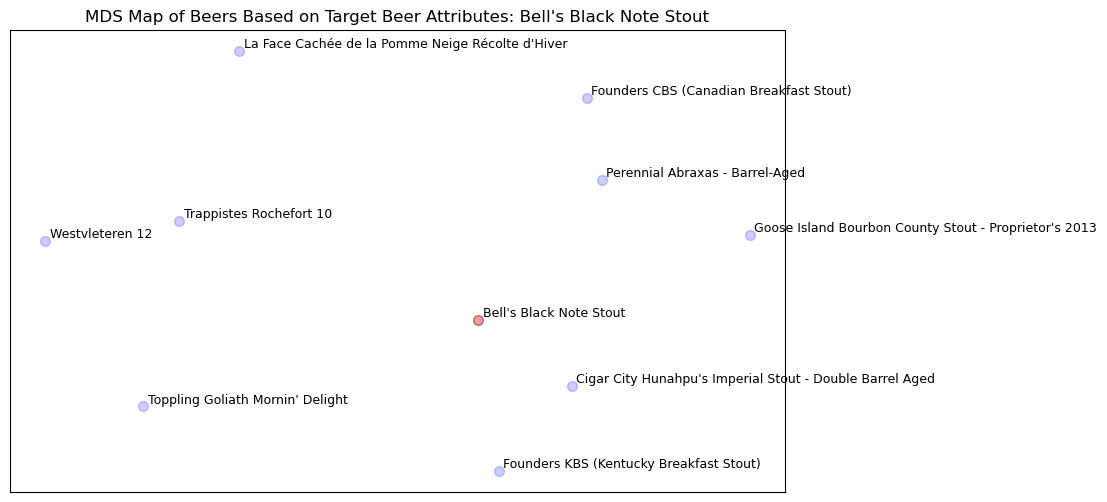

In [241]:
# Prepare data
beer_vectors = feature_df.loc[selected_beers].values
beer_vectors = np.nan_to_num(beer_vectors)

# Apply MDS for visualization
mds = MDS(n_components=2, random_state=42)
beer_coords = mds.fit_transform(beer_vectors)
mds_df = pd.DataFrame(beer_coords, index=selected_beers, columns=['X', 'Y'])

# Plot the MDS map
plt.figure(figsize=(10, 6))
for beer in selected_beers:
    x, y = mds_df.loc[beer]
    if beer == chosen_beer:
        plt.scatter(x, y, color='red', label=f'Target: {beer}', s=50, edgecolor='black', alpha = 0.4)
    else:
        plt.scatter(x, y, color='blue', label=f'Non-target: {beer}', s=50, alpha=0.2)
    plt.text(x + 0.02, y + 0.02, beer, fontsize=9)

plt.title(f'MDS Map of Beers Based on Target Beer Attributes: {chosen_beer}')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.show()

We then plotted the target beer (in red) in an MDS map alongside all of the other beers (blue) to show the relative proximity across the beer attributes. In the MDS map the closer a beer denoted by a blue dot is to the target beer, the closer the attributes are.